# Incoherent FZA lensless imaging simuation
![](https://www.opticsjournal.net/richHtml/gxjmgc/2022/30/18/2280/img_1.jpg)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
di = 3.0          # distance between FZA and sensor
z1 = 20.0         # distance between FZA and object plane
x1 = 0.0
y1 = 0.0
Lx1 = 20.0       # length of object
dp = 0.01        # pixel size
Nx = 512         # number of pixels
Ny = 512

## Define Fresnel Zone Aperture
The amplitude of FZA Mask can be regarded as:
$$
T\left( r \right)\,=\,\frac{1}{2}\,+\,\frac{1}{2}\cos \left( {\frac{{\pi r^2}}{{r_1^2}}} \right)
$$

Without considering diffraction, the FZA mask is the point spread function of the imaging system. To simplify the imaging model, PSF is a linearly scaled version of FZA, corresponding to the ratio of di and z1. The detailed derivation process can be found at Part. Materials and methods of [Paper](https://www.nature.com/articles/s41377-020-0289-9)

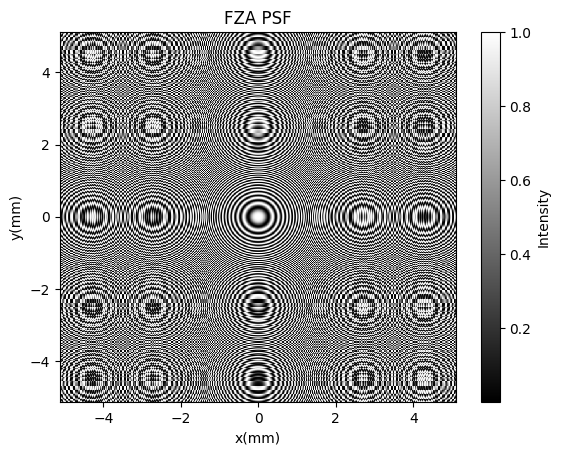

In [3]:
def FZA(S, N, r1):
    x = np.linspace(-S / 2, S / 2 - S / N, N)
    y = np.linspace(-S / 2, S / 2 - S / N, N)
    X, Y = np.meshgrid(x, y)
    r_2 = X**2 + Y**2
    mask = 0.5 * (1 + np.cos(np.pi * r_2 / r1**2))
    return mask, X, Y

S = 2 * dp * Nx  # 孔径直径
r1 = 0.23        # FZA常数
M = di / z1
ri = (1 + M) * r1

mask, X, Y=FZA(S,2*Nx,ri)

plt.pcolormesh(X, Y, mask, cmap='gray')
plt.title('FZA PSF')
plt.colorbar(label='Intensity')
plt.xlabel('x(mm)')
plt.ylabel('y(mm)')
plt.show()

## Simulate wave propagation of FZA
Here we simulate the point spread function of FZA mask. The PSF can be regarded as the intensity distribution on the observation plane when illuminated by an ideal point source or planar wave. We created several optical layers with pyoptics: Planar wave source, FZA mask and limited aperture

In [4]:
import pyoptics
binary_mask = np.ones_like(mask)
binary_mask[mask<0.5]=0
binary_mask[mask>=0.5]=1
source = pyoptics.PlaneWaveLayer(L=2*Nx*dp,N=2*Nx,wavelength=632e-6,angleX=0.8)
FZA = pyoptics.CustomLayer(L=2*Nx*dp,N=2*Nx,wavelength=632e-6,mag=binary_mask)
aperture = pyoptics.ApertureLayer(L=2*Nx*dp,N=2*Nx,wavelength=632e-6,radius=400*dp)
layer_list = [[source,FZA,aperture]]
distance_list=[3]

OS = pyoptics.OpticsSystem(layer_list, distance_list)

z = sum(distance_list)
# z(m): propagation distance along Z axis
z_step = 5e-2
# z_step: simulation step of Z axis

# simulation of light filed propagation along Z axis
number_of_z_step = int(z / z_step)

field_along_z = OS.field_propagation_along_z(z, z_step)
YZ_field = np.abs(field_along_z[:, 2*Nx // 2])
z_total = np.arange(0, number_of_z_step) * z_step

intensity_at_z = np.abs(field_along_z[-1,:])**2
intensity_at_z = intensity_at_z - np.mean(intensity_at_z)

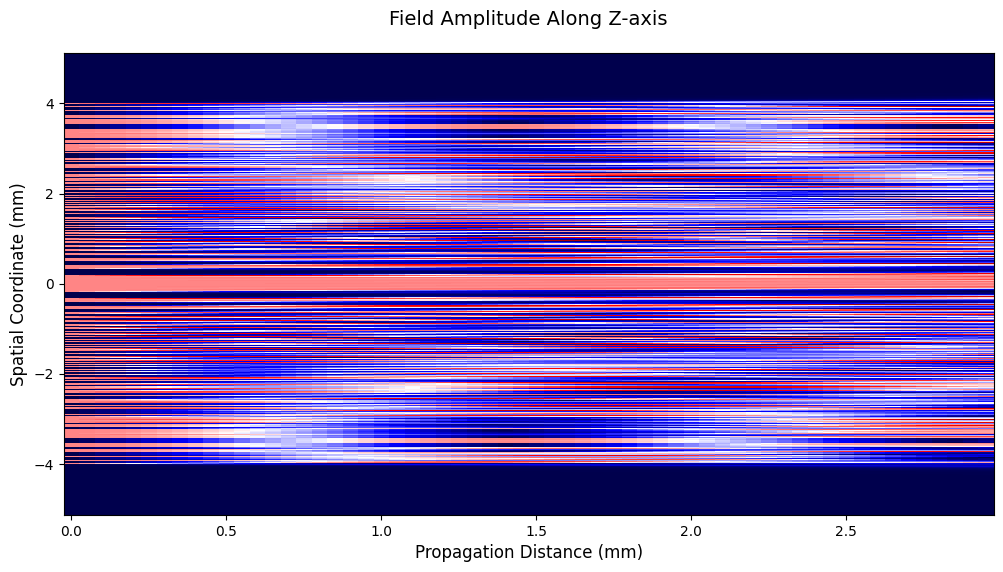

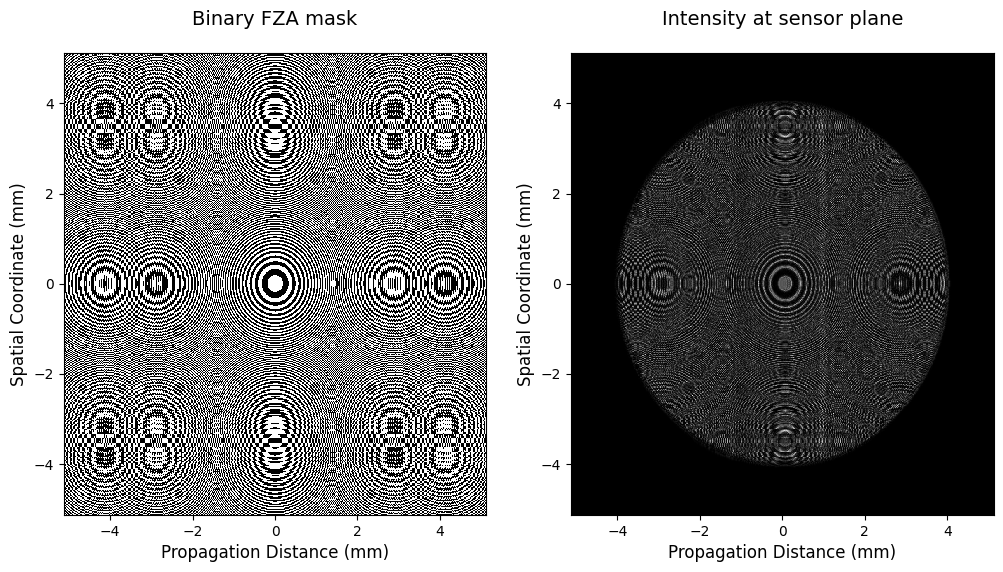

In [5]:
fig = plt.figure(figsize=(12, 6))

plt.pcolormesh(z_total, source.x, YZ_field.T, cmap='seismic')
plt.xlabel('Propagation Distance (mm)', fontsize=12)
plt.ylabel('Spatial Coordinate (mm)', fontsize=12)
plt.title('Field Amplitude Along Z-axis', fontsize=14, pad=20)
plt.show()

fig = plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.pcolormesh(source.x, source.y, binary_mask, cmap='gray')
plt.xlabel('Propagation Distance (mm)', fontsize=12)
plt.ylabel('Spatial Coordinate (mm)', fontsize=12)
plt.title('Binary FZA mask', fontsize=14, pad=20)

plt.subplot(1,2,2)
plt.pcolormesh(source.x, source.y, intensity_at_z, cmap='gray')
plt.xlabel('Propagation Distance (mm)', fontsize=12)
plt.ylabel('Spatial Coordinate (mm)', fontsize=12)
plt.title('Intensity at sensor plane', fontsize=14, pad=20)
plt.show()

In [6]:
## Simulate FZA lensless imaging with linear convolution model

In [7]:
# load image pattern
from PIL import Image
from scipy.ndimage import rotate
from skimage.transform import resize
Obj1 = np.zeros((Nx, Ny))

imageA = np.array(Image.open('../assets/cameraman.tif').convert('L'))

imageA = resize(imageA, (Nx, Ny), order=0)
imageA = rotate(imageA, 0)
px, py = imageA.shape
px_start = (Nx - px) // 2
py_start = (Ny - py) // 2
Obj1[px_start:px_start + px, py_start:py_start + py] = imageA

Like most incoherent linear imaging system, the intensity distribution $I$ on sensor plane can be expressed as:
$$
I=O\ast S
$$
where $S$ is the PSF at sensor plane, generated by designed FZA pattern. $O$ can be regarded as a perfect imaging results through the ideal pinhole.

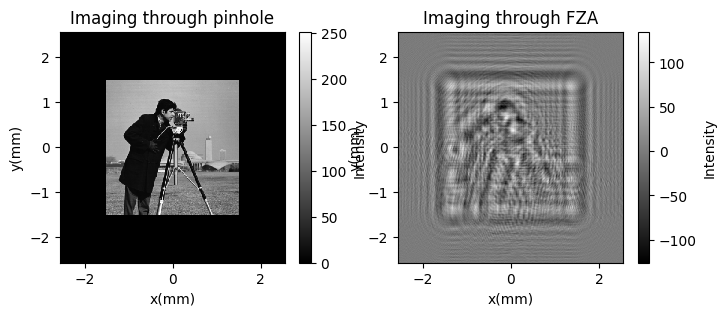

In [8]:
from scipy.interpolate import RegularGridInterpolator
from skimage.color import rgb2gray
from scipy.signal import convolve2d
import scipy
# Perform 2D convolution (equivalent to 'same' in MATLAB)

def pinhole(O, di, x, y, z, Lx, dp, Nx):
    # Convert to grayscale if the input is RGB
    if len(O.shape) == 3 and O.shape[2] == 3:
        O = rgb2gray(O)

    m, n = O.shape
    # Compute object height (Ly) based on aspect ratio
    Ly = m * Lx / n  # Object height in mm

    # Magnification factor
    M = di / z

    # Image dimensions
    Lxi = M * Lx       # Image width
    Lyi = M * Ly       # Image height
    xi = M * x         # Shift in x
    yi = M * y         # Shift in y
    ds = Lxi / n       # Sampling distance in mm

    # Sensor dimensions
    Ny = Nx
    W = Nx * dp        # Sensor width
    H = Ny * dp        # Sensor height

    # Create the object plane grid
    x_coords = np.linspace(xi - Lxi / 2, xi + Lxi / 2 - ds, n)
    y_coords = np.linspace(yi + Lyi / 2 - ds, yi - Lyi / 2, m)

    # Create the sensor plane grid
    Xq, Yq = np.meshgrid(
        np.linspace(-W / 2, W / 2 - dp, Nx),
        np.linspace(H / 2 - dp, -H / 2, Ny)
    )

    # Use RegularGridInterpolator for interpolation
    interpolator = RegularGridInterpolator((y_coords, x_coords), O, method='linear', bounds_error=False, fill_value=0)

    # Flatten the query points (Xq, Yq) for interpolation
    query_points = np.stack([Yq.ravel(), Xq.ravel()], axis=-1)

    # Interpolate the image from object plane to sensor plane
    I = interpolator(query_points).reshape(Yq.shape)

    return I,Xq,Yq

Obj,Xq,Yq = pinhole(Obj1,di,0,0,20,20,dp,Nx)

I = scipy.signal.fftconvolve(Obj, mask, mode='same') * 2 * dp * dp / ri**2

# Subtract the mean of I
I = I - np.mean(I)
fig = plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.pcolormesh(Xq,Yq,Obj,cmap='gray')
plt.colorbar(label='Intensity')
plt.title("Imaging through pinhole")
plt.xlabel('x(mm)')
plt.ylabel('y(mm)')

plt.subplot(1, 2, 2)
plt.pcolormesh(Xq,Yq,I,cmap='gray')
plt.colorbar(label='Intensity')
plt.title("Imaging through FZA")
plt.xlabel('x(mm)')
plt.ylabel('y(mm)')
plt.show()

## Reconstruction with back propagation
Although it is a incoherent imaging process, the imaging equation is quite like an in-line digital holography, which is assumed as a coherent wave interference process.

It indicates that we can perform back propagation coherently to recover the wavefront. In the Fresnel approxmiation, the reconstructed wavefront may be written as:
$$
O_R\left( {{\mathbf{r}}_o} \right)\,=\,\frac{{\exp \left( {i2\pi d/\lambda } \right)}}{{i\lambda d}}{\int\!\!\!\!\!\int} {I\left( {\mathbf{r}} \right)\exp \left[ {\frac{{i\pi }}{{\lambda d}}\left| {{\mathbf{r}}\,-\,{\mathbf{r}}_o} \right|^2} \right]dS}
$$

You may notice that the reconstructed images is not perfect, because the wavefront contains so-called twins-image. It is shows as a out-focus image added on the reconstruction. TV or other optimization algorithm can be applied to solve the problem, which are not presented in this notebook.

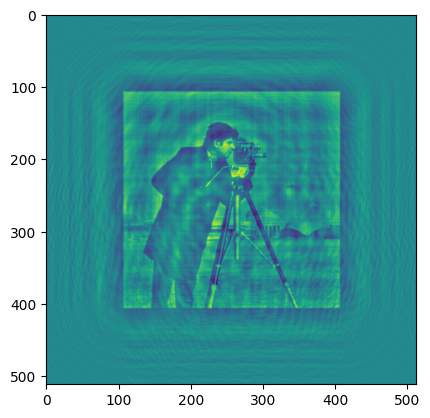

In [9]:
def MyAdjointOperatorPropagation(I, H):
    FI = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(I)))
    Or = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(FI / H)))
    Or = np.real(Or)
    return Or

fu_max = 0.5 / dp
fv_max = 0.5 / dp
du = 2 * fu_max / Nx
dv = 2 * fv_max / Ny

# Create the (u, v) grid using numpy's meshgrid
u = np.arange(-fu_max, fu_max, du)
v = np.arange(-fv_max, fv_max, dv)
v, u = np.meshgrid(v, u)  # Note: Reversed order compared to MATLAB

# Define the Fresnel transfer function
H = 1j * np.exp(-1j * (np.pi * ri**2) * (u**2 + v**2))

# Call the adjoint operator propagation function (assuming I is defined)
Or = MyAdjointOperatorPropagation(I, H)

plt.imshow(Or)
plt.show()